In [1]:
from argparse import Namespace
from pathlib import Path
from functools import partial
from collections import (
    OrderedDict,
    Counter,
    defaultdict
)

# torch 
import torch 
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence,pad_packed_sequence
from torch.utils.data import default_collate
# other 
from torchtext import vocab
try:
    from torchdata import datapipes as dp
    from torchdata.dataloader2 import DataLoader2
except:
    !pip install torchdata==0.5.1
    from torchdata import datapipes as dp
    from torchdata.dataloader2 import DataLoader2

    from google.colab import drive
    drive.mount('/content/drive')

# manipulation 
import numpy as np

# visual
import seaborn as sns
import matplotlib.pyplot as plt


#other
from tqdm import tqdm
from nltk.translate import bleu_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 37.5 MB/s eta 0:00:00
Mounted at /content/drive


In [26]:
args = Namespace(
    colab = True,
    # data
    root = "/content/drive/Othercomputers/My PC/drive/",
    data_base_path = "data/mt/",
    dataset = ["train","test","val"],
    
    # vocab
    mask_tkn = "<MASK>",
    ukn_tkn = "<UKN>",
    beg_tkn = "<BEG>",
    end_tkn = "<END>",
    
    # Training
    batch_size =  64,
    num_epochs = 100,
    learning_rate = 1e-3,
    early_stopping_criteria =5 ,
    
    
    # model
    source_embedding = 64,
    target_embedding = 64,
    encoding_size = 64,
    model_base_path = "models/seq_model/mt/",
    model_filename = "model.pth",
    
    # runtime
    cuda = torch.cuda.is_available(),
    device = "cuda" if torch.cuda.is_available() else "cpu",
    
)
for k,v in args._get_kwargs():
    if "base" in k:
        setattr(args,k,args.root+v)
        Path(getattr(args,k)).mkdir(parents=True,exist_ok=True)

# Datapipe

## build pipe dict

In [3]:
def build_pipe_dict(args=args):
    pipe_dict = {}
    for fname in args.dataset:
        pipe = dp.iter.FileOpener([args.data_base_path+f"{fname}.csv"])
        pipe_dict[fname] = pipe.parse_csv(skip_lines=1)
    return pipe_dict          

In [4]:
pipe_dict = build_pipe_dict(args)
pipe_dict

{'train': CSVParserIterDataPipe,
 'test': CSVParserIterDataPipe,
 'val': CSVParserIterDataPipe}

In [5]:
{k:len(list(pipe)) for k,pipe in pipe_dict.items()}

{'train': 9138, 'test': 1969, 'val': 1955}

In [6]:
{k:next(iter(pipe)) for k,pipe in pipe_dict.items()}

{'train': ["he 's the cutest boy in town .",
  "c'est le garçon le plus mignon en ville ."],
 'test': ["he 's a man of his word .", "c'est un homme de parole ."],
 'val': ["he 's all right .", 'il va bien .']}

## build vocab dict

In [7]:
def create_vocab(counter,max_seq_length,args):
    sort_tuples = sorted(counter.items(),key=lambda kf :(-kf[1],kf[0]))
    vocabulary = vocab.vocab(ordered_dict=OrderedDict(sort_tuples),
                        specials=[args.mask_tkn,
                                  args.ukn_tkn,
                                  args.beg_tkn,
                                  args.end_tkn])
    vocabulary.max_seq_length = max_seq_length
    vocabulary.set_default_index(vocabulary[args.ukn_tkn])
    return vocabulary

In [8]:
def build_vocab_dict(train_pipe,args=args):
    counter_dict = defaultdict(Counter)
    max_seq_len_dict = defaultdict(int)
    for row in train_pipe:
        for key,sent in zip(["source","target"],row):
            max_seq_len_dict[key] = max(max_seq_len_dict[key],len((sent_list:=sent.split(" "))))
            counter_dict[key].update(sent_list)
    
    return {k:create_vocab(counter_dict[k],max_seq_len_dict[k],args)
            for k in counter_dict.keys()}    

In [9]:
vocab_dict = build_vocab_dict(pipe_dict["train"],args)
vocab_dict

{'source': Vocab(), 'target': Vocab()}

In [10]:
{k:len(v) for k,v in vocab_dict.items()}

{'source': 3025, 'target': 4902}

In [11]:
{k:v.max_seq_length for k,v in vocab_dict.items()}

{'source': 23, 'target': 24}

## build dataset dict

In [12]:
def vectorize(indices,seq_length,mask_idx):
    vector = np.full(shape=seq_length,
                     fill_value=mask_idx,
                     dtype=np.int64)
    vector[:len(indices)] = indices
    return vector

def get_source_indices(source_text,source_vocab,args=args):
    indices = [source_vocab[args.beg_tkn]]
    indices.extend(source_vocab.lookup_indices(source_text.split(" ")))
    indices.append(source_vocab[args.end_tkn])
    
    return indices

def get_target_indices(target_text,target_vocab,args=args):
    indices = target_vocab.lookup_indices(target_text.split(" "))
    target_x = [target_vocab[args.beg_tkn]] + indices
    target_y = indices + [target_vocab[args.end_tkn]]
    return target_x ,target_y

def create_dataset(vocab_dict,args,row):
    source_indices = get_source_indices(source_text=row[0],
                                        source_vocab=vocab_dict["source"],
                                        args=args)
    source_vector = vectorize(source_indices,
                              seq_length = vocab_dict["source"].max_seq_length + 2,
                              mask_idx= vocab_dict["source"][args.mask_tkn])
    
    target_x_indices ,target_y_indices = get_target_indices(target_text=row[1],
                                                            target_vocab=vocab_dict["target"],
                                                            args=args)
    
    target_x_vector = vectorize(target_x_indices,
                              seq_length = vocab_dict["target"].max_seq_length + 1,
                              mask_idx= vocab_dict["target"][args.mask_tkn])
    
    target_y_vector = vectorize(target_y_indices,
                              seq_length = vocab_dict["target"].max_seq_length + 1,
                              mask_idx= vocab_dict["target"][args.mask_tkn])
    
    return {"source_vector":source_vector,
            "target_x_vector":target_x_vector,
            "target_y_vector":target_y_vector,
            "source_length":len(source_indices)}
    
    
def collate_fn(args,batch):
    data_dict = default_collate(batch)
    lengths = data_dict["source_length"].numpy()
    sorted_lengths = lengths.argsort()[::-1].tolist()
    
    return {k:v[sorted_lengths].to(args.device)
            for k,v in data_dict.items()}
        
        

In [13]:
def build_dataset_pipe(pipe_dict,vocab_dict,args):
    dataset_pipe = {}
    fn = partial(create_dataset,vocab_dict,args)
    for dataset,pipe in pipe_dict.items():
        if dataset == "train":
            pipe = pipe.shuffle()
        
        pipe = pipe.map(fn)
        pipe = pipe.batch(args.batch_size,drop_last=True)
        pipe = pipe.collate(partial(collate_fn,args))
        
        dataset_pipe[dataset] = pipe
        
    return dataset_pipe

In [14]:
dataset_dict = build_dataset_pipe(pipe_dict,vocab_dict,args)
dataset_dict

{'train': CollatorIterDataPipe,
 'test': CollatorIterDataPipe,
 'val': CollatorIterDataPipe}

In [15]:
sample = next(iter(dataset_dict["train"]))
{k:v.size() for k,v in sample.items()}

{'source_vector': torch.Size([64, 25]),
 'target_x_vector': torch.Size([64, 25]),
 'target_y_vector': torch.Size([64, 25]),
 'source_length': torch.Size([64])}

# Model

## Encoder

In [16]:
class NMTEncoder(nn.Module):
    def __init__(self,source_embedding_size,source_vocab_size,rnn_hidden_size,
                 padding_idx=0) -> None:
        super().__init__()
        self.source_embedding = nn.Embedding(embedding_dim=source_embedding_size,
                                             num_embeddings=source_vocab_size,
                                             padding_idx=padding_idx)
        self.birnn = nn.GRU(input_size=source_embedding_size,
                             hidden_size=rnn_hidden_size,
                             bidirectional=True,
                             batch_first=True)
    
    def forward(self,source_vec,source_len):
        # shape [batch,seq]
        x_embedded = self.source_embedding(source_vec)
        # shape [batch,seq,emb]
        x_packed = pack_padded_sequence(input=x_embedded,
                                        lengths=source_len.detach().cpu().numpy(),
                                        batch_first=True)
        
        x_birnn_out ,x_birnn_h = self.birnn(x_packed)
        # shape x_birnn_out will be in packed sequence since we used packed sequence
        # when we convert into padded seq [batch,seq,2*hidden_size]
        # shape x_birnn_h [2,batch,rnn_hidden_size]
        
        # permute to [batch,2,rnn_hidden_size]
        x_birnn_h = x_birnn_h.permute(1,0,2)
        # flatten the x_birnn_h to [batch,2*rnn_hidden_size]
        x_birnn_h = x_birnn_h.contiguous().view(x_birnn_h.shape[0],-1)
        
        x_unpacked , _ = pad_packed_sequence(x_birnn_out,batch_first=True)
        
        return x_unpacked , x_birnn_h
        

In [17]:
def attention_mechanism(encode_state_vector,query_vector):
    batch_size , seq_size , emb_size = encode_state_vector.size()
    vector_score = torch.sum(encode_state_vector*query_vector.view(batch_size,1,emb_size),dim=2)
    vector_prob = F.softmax(vector_score,dim=1)
    weight_vector = encode_state_vector * vector_prob.view(batch_size,seq_size,1)
    context_vector = torch.sum(weight_vector,dim=1)
    return context_vector,vector_prob,vector_score

In [18]:
class NMTDecoder(nn.Module):
    def __init__(self,embedding_size,num_embeddings,rnn_hidden_size,
                 padding_idx =0) -> None:
        super().__init__()
        self._rnn_hidden_size = rnn_hidden_size
        self.target_embedding = nn.Embedding(num_embeddings=num_embeddings,
                                             embedding_dim=embedding_size,
                                             padding_idx=padding_idx)
        self.decoder_cell = nn.GRUCell(input_size=embedding_size+rnn_hidden_size,
                                       hidden_size=rnn_hidden_size)
        self.hidden_map = nn.Linear(rnn_hidden_size,rnn_hidden_size)
        self.classifier = nn.Linear(2*rnn_hidden_size,num_embeddings)
    
    def _init_context_vectors(self,batch_size):
        return torch.zeros(size=(batch_size,self._rnn_hidden_size))
    
    def forward(self,encode_state,initial_hidden,target_sequence):
        # assuming the target sequence shape [batch,TS]
        # permute to [TS,batch]
        batch_size,out_seq_size = target_sequence.size()
        target_sequence = target_sequence.permute(1,0)
        
        context_vector  = self._init_context_vectors(batch_size).to(encode_state.device)
        h_t = self.hidden_map(initial_hidden)
        
        output_vectors = []
        
        self._cache_p_attn =[]
        self._cache_ht = []
        self._decoder_state = encode_state.detach().cpu().numpy()
        
        
        for xt in target_sequence:
            xt_vector = self.target_embedding(xt)
            rnn_input = torch.cat((xt_vector,context_vector),dim=1)
            
            h_t = self.decoder_cell(rnn_input,h_t)
            self._cache_ht.append(h_t.detach().cpu().numpy())
            
            # attention mechanism
            context_vector,p_attn,_ = attention_mechanism(encode_state,query_vector=h_t)
            self._cache_p_attn.append(p_attn.detach().cpu().numpy())
            
            pred_vector = torch.cat((context_vector,h_t),dim=1)
            score_yt = self.classifier(F.dropout(pred_vector,0.3))
            
            output_vectors.append(score_yt)
        
        output_vectors = torch.stack(output_vectors).permute(1,0,2)
        
        return output_vectors
    

In [19]:
class NMTModel(nn.Module):
    def __init__(self,source_vocab_size,source_embedding,
                 target_vocab_size,target_embedding,encoding_size,
                 padding_idx=0) -> None:
        super().__init__()
        self.encoder = NMTEncoder(source_embedding_size=source_embedding,
                                  source_vocab_size=source_vocab_size,
                                  rnn_hidden_size=encoding_size,
                                  padding_idx=padding_idx)
        decoding_size = 2 * encoding_size
        self.decoder = NMTDecoder(embedding_size=target_embedding,
                                  num_embeddings=target_vocab_size,
                                  rnn_hidden_size=decoding_size)
        
    def forward(self,x_source,x_source_length,x_target):
        encoder_state,hidden_state = self.encoder(x_source,x_source_length)
        decoder_state = self.decoder(encode_state=encoder_state,
                                     initial_hidden=hidden_state,
                                     target_sequence=x_target)
        return decoder_state

In [20]:
def normalize_size(y_pred,y_true):
    if y_pred.ndim == 3:
        """y_pred in the shape [batch_size,seq_size,vocab_size]
        since we have to predict the vocab size then we have to change the 
        dimension into [batch*seq,vocab_size] which in the form of [N,C]
        
        N-token in the all the sample seq
        C-class we want to predict ie vocab size"""
        y_pred = y_pred.contiguous().view(-1,y_pred.size(2))
    if y_true.ndim == 2:
        """y_true in the shape [batch,seq] then we need to convert into
        [batch*seq] which in the form of [N,] 
        
        N- token in all the sample seq"""        
        y_true = y_true.contiguous().view(-1)
        
    return y_pred,y_true

def sequence_loss(y_pred,y_true,mask_index):
    y_pred,y_true = normalize_size(y_pred,y_true)
    return F.cross_entropy(y_pred,y_true,ignore_index=mask_index)

def compute_acc(y_pred,y_true,mask_index):
    y_pred,y_true = normalize_size(y_pred,y_true)
    _,y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices,y_true).float()
    valid_indices = torch.ne(y_true,mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()
    
    return n_correct /n_valid

# Training

## Helper function

In [21]:
def make_train_state(args=args):
    return {"stop_early":False,
            "early_stopping_step":0,
            "early_stopping_val":1e5,
            "epoch_index":0,
            "model_filepath":args.model_base_path+args.model_filename,
            "train_loss":[],
            "train_acc":[],
            "val_loss":[],
            "val_acc":[],
            "test_loss":-1,
            "test_acc":-1}

def update_train_state(train_state,model,args=args):
    if train_state["epoch_index"] == 0:
        torch.save(model.state_dict(),train_state["model_filepath"])
        train_state["stop_early"] = False
    
    elif train_state["epoch_index"] >= 1:
        loss_tm1 , loss_t = train_state["val_loss"][-2:]
        if loss_t >= train_state["early_stopping_val"]:
            train_state["early_stopping_step"] +=1
        else:
            torch.save(model.state_dict(),train_state["model_filepath"])
            train_state["early_stopping_step"] = 0
            
        train_state["stop_early"] = train_state["early_stopping_step"] >= args.early_stopping_criteria
    
    return train_state

## initialize

In [22]:
pipe_dict = build_pipe_dict()
vocab_dict = build_vocab_dict(pipe_dict["train"])
dataset_dict = build_dataset_pipe(pipe_dict,vocab_dict,args)

In [28]:
args.source_vocab_size = len(vocab_dict["source"])
args.target_vocab_size = len(vocab_dict["target"])
args.padding_idx = vocab_dict["source"][args.mask_tkn]

In [24]:
model = NMTModel(source_vocab_size=args.source_vocab_size,
                 source_embedding=args.source_embedding,
                 target_vocab_size=args.target_vocab_size,
                 target_embedding=args.target_embedding,
                 encoding_size=args.encoding_size,
                 padding_idx=args.padding_idx).to(args.device)

optimizer = optim.Adam(params=model.parameters(),
                       lr=args.learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode="min",
                                                 factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

## loop

In [29]:
for epoch_index in tqdm(range(args.num_epochs)):
    train_state["epoch_index"] = epoch_index
    
    # get the data
    batch_generator = DataLoader2(datapipe=dataset_dict["train"])
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        model.zero_grad()
        logits = model(x_source=batch_dict["source_vector"],
                       x_source_length=batch_dict["source_length"],
                       x_target=batch_dict["target_x_vector"])
        
        # loss
        loss = sequence_loss(logits,batch_dict["target_y_vector"],args.padding_idx)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) /(batch_idx+1)
        
        # acc
        acc_t = compute_acc(logits,batch_dict["target_y_vector"],args.padding_idx)
        running_acc += (acc_t - running_acc) / (batch_idx+1)
        
        loss.backward()
        optimizer.step()
        
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)
    
    # iterate over the val 
    batch_generator = DataLoader2(dataset_dict["val"])
    running_loss = 0.0
    running_acc = 0.0
    model.eval()
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        with torch.inference_mode():
            logits = model(x_source=batch_dict["source_vector"],
                       x_source_length=batch_dict["source_length"],
                       x_target=batch_dict["target_x_vector"])
            
            # loss
            loss = sequence_loss(logits,batch_dict["target_y_vector"],args.padding_idx)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) /(batch_idx+1)
            
            # acc
            acc_t = compute_acc(logits,batch_dict["target_y_vector"],args.padding_idx)
            running_acc += (acc_t - running_acc) / (batch_idx+1)   
            
    train_state["val_loss"].append(running_loss)         
    train_state["val_acc"].append(running_acc)
    
    train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

    
    scheduler.step(train_state["val_loss"][-1])
    
    if train_state["stop_early"]:
        break          

100%|██████████| 100/100 [12:35<00:00,  7.55s/it]


In [35]:
def get_sentence_from_indices(indices,vocab,return_string=False,args=args):
    idx_to_token = vocab.get_itos()
    out = []
    for index in indices:
        if index == vocab[args.beg_tkn]:
            continue
        elif index == vocab[args.mask_tkn] or index == vocab[args.end_tkn] :
            break
        else:
            out.append(idx_to_token[index])
    if return_string:
        return " ".join(out)
    else:
        return out

In [36]:
chencherry = bleu_score.SmoothingFunction()

In [37]:
class NMTSampler:
    def __init__(self,model,vocab_dict) -> None:
        self.model = model
        self.vocab_dict = vocab_dict
        
    def apply_to_batch(self,batch_dict):
        self._last_batch = batch_dict
        y_pred = model(x_source=batch_dict["source_vector"],
                       x_source_length=batch_dict["source_length"],
                       x_target=batch_dict["target_x_vector"])
        self._last_batch["y_pred"] = y_pred
        attention_batched = np.stack(self.model.decoder._cache_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
        
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['source_vector'][index].cpu().detach().numpy()
        vocab = self.vocab_dict["source"]
        return get_sentence_from_indices(indices, vocab, return_string=return_string)

    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['target_y_vector'][index].cpu().detach().numpy()
        vocab = self.vocab_dict["target"]
        return get_sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_sampled_sentence(self, index, return_string=True):
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vocab_dict["target"]
        return get_sentence_from_indices(sentence_indices, vocab, return_string=return_string)

    def get_ith_item(self, index, return_string=True):
        output = {"source": self._get_source_sentence(index, return_string=return_string), 
                  "reference": self._get_reference_sentence(index, return_string=return_string), 
                  "sampled": self._get_sampled_sentence(index, return_string=return_string),
                  "attention": self._last_batch['attention'][index]}
        
        reference = output['reference']
        hypothesis = output['sampled']
        
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
        
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                    hypothesis=hypothesis,
                                                    smoothing_function=chencherry.method1)
        
        return output

In [38]:
model = model.eval().to(args.device)

sampler = NMTSampler(model,vocab_dict)


batch_generator = DataLoader2(dataset_dict["test"])
                  
                  

test_results = []
for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(args.batch_size):
        test_results.append(sampler.get_ith_item(i, False))

(0.554365743660909, 0.5566771389461691)

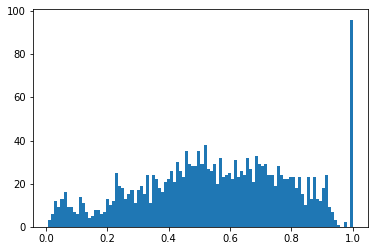

In [39]:
plt.hist([r['bleu-4'] for r in test_results], bins=100);
np.mean([r['bleu-4'] for r in test_results]), np.median([r['bleu-4'] for r in test_results])

In [42]:
batch_generator = DataLoader2(dataset_dict["val"])

batch_dict = next(iter(batch_generator))

model = model.eval().to(args.device)
sampler = NMTSampler(model,vocab_dict)
sampler.apply_to_batch(batch_dict)

In [43]:
all_results = []
for i in range(args.batch_size):
    all_results.append(sampler.get_ith_item(i, False))

In [44]:
top_results = [x for x in all_results if x['bleu-4']>0.1]
len(top_results)

58

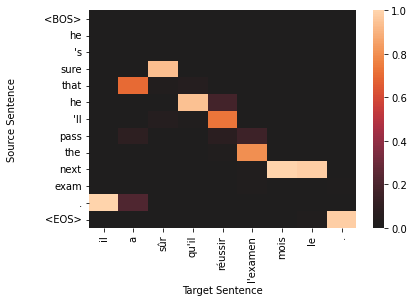

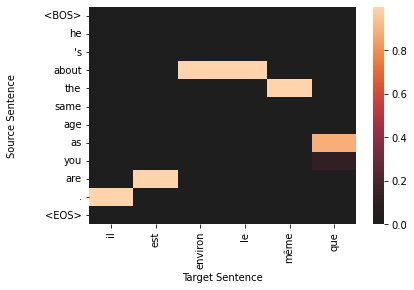

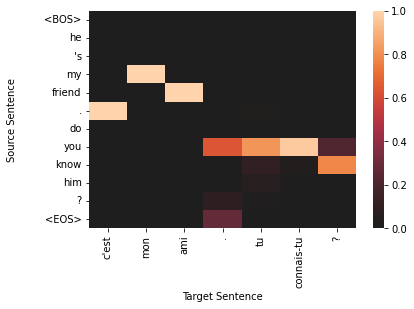

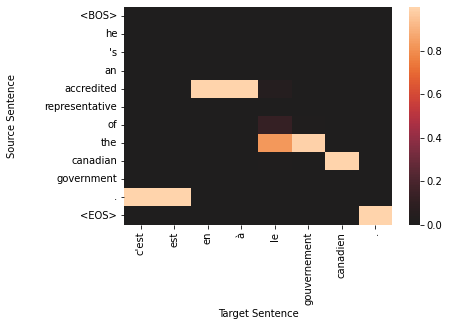

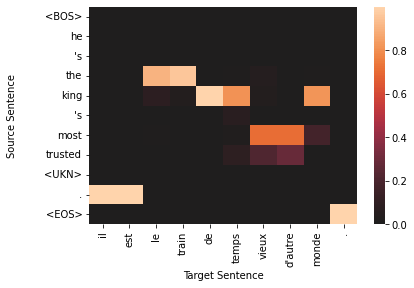

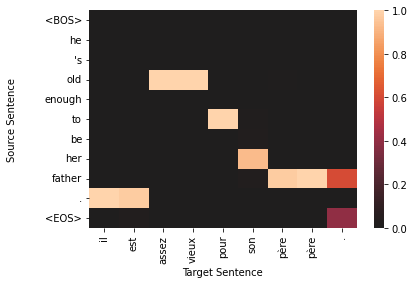

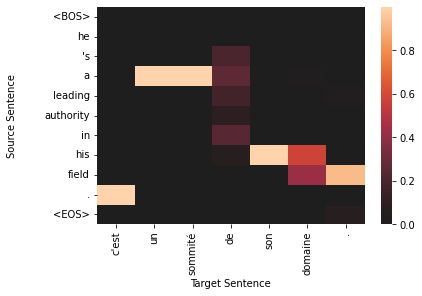

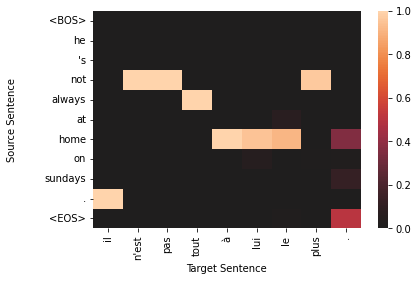

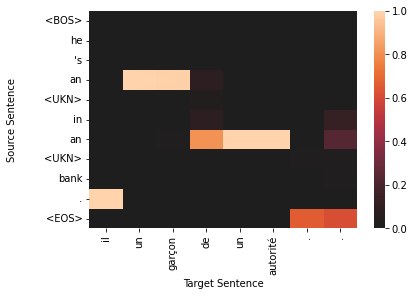

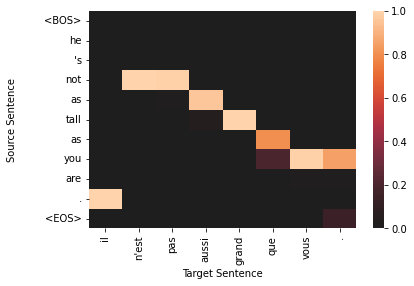

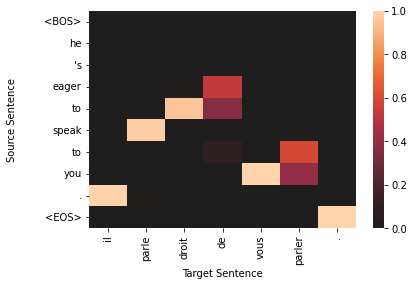

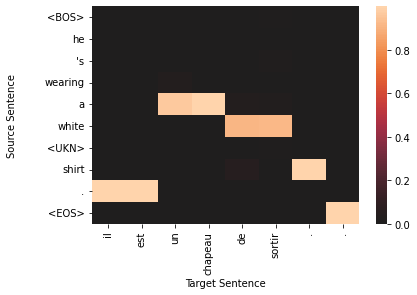

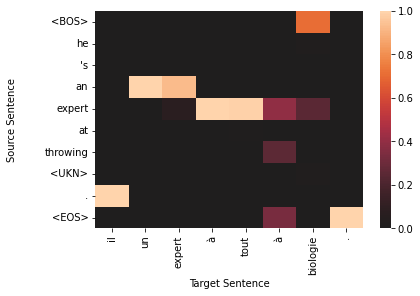

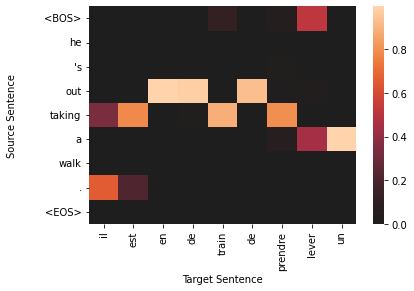

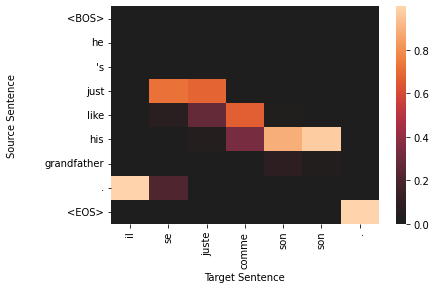

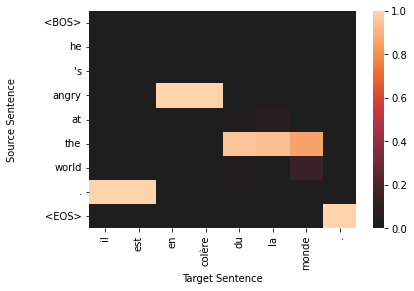

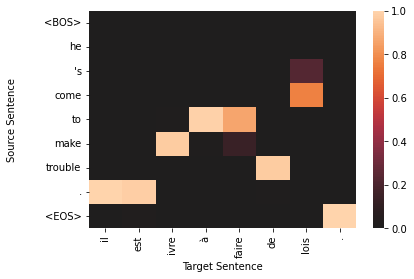

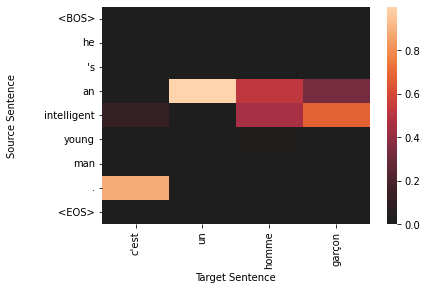

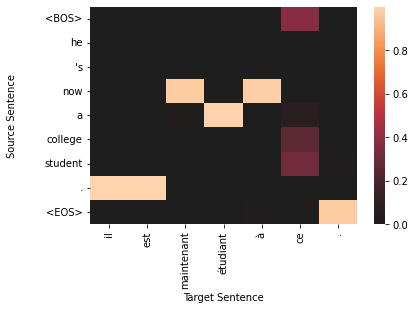

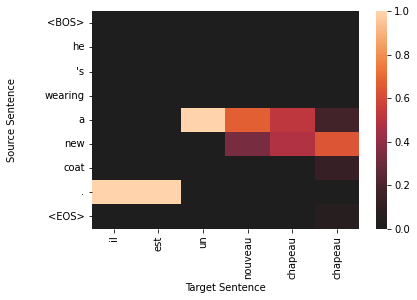

In [45]:
for sample in top_results[:20]:
    plt.figure()
    target_len = len(sample['sampled'])
    source_len = len(sample['source'])

    attention_matrix = sample['attention'][:target_len, :source_len+2].transpose()#[::-1]
    ax = sns.heatmap(attention_matrix, center=0.0)
    ylabs = ["<BOS>"]+sample['source']+["<EOS>"]
    #ylabs = sample['source']
    #ylabs = ylabs[::-1]
    ax.set_yticklabels(ylabs, rotation=0)
    ax.set_xticklabels(sample['sampled'], rotation=90)
    ax.set_xlabel("Target Sentence")
    ax.set_ylabel("Source Sentence\n\n")